In [1]:
import ee
import ipyleaflet
import os
import time
import skvideo.io
import rasterio as rio
from rasterio import plot
import numpy as np
from google.cloud import storage
import matplotlib.pyplot as plt

BUCKET = os.environ.get('EE_BUCKET') or 'ee-export-744hn9bz'
PROJECT = os.environ.get('EE_PROJECT') or 'fgassert-ee'

In [2]:
ee.Initialize()

In [3]:
credential_file = '.credentials.json'
with open(credential_file, 'w') as f:
    f.write(os.environ.get('GEE_JSON'))
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=credential_file

In [4]:
gsClient = storage.Client(PROJECT)

/usr/local/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
# utility funcs
def GetTileLayerUrl(eeImage):
    map_id = ee.Image(eeImage).getMapId()
    tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
    return tile_url_template.format(**map_id)

def TileLayer(eeImage):
    return ipyleaflet.TileLayer(url=GetTileLayerUrl(eeImage))

def ShowLayer(eeImage):
    Map = ipyleaflet.Map(center=(48.2, 16.3), zoom=2, layout={'height':'200px'})
    Map.add_layer(TileLayer(eeImage))
    return Map

In [6]:
ic = ee.ImageCollection('users/resourcewatchlandcover/HYDE/Anthromes')
inClasses = [11, 12, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 51, 52, 53, 54, 61, 62, 63, 70]
outClasses = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
colorMap = [
  '9a1e13', #11 urban
  '9a1e13', #12 dense settlements
  '0070ff', #21 village-rice
  '0070ff', #22 village-irrigated
  'a900e6', #23 village-rainfed
  'a900e6', #24 village-pastoral
  'e6e600', #31 croplands-residential-irrigated
  'e6e600', #32 croplands-residential-rainfed
  'e6e600', #33 croplands-populated
  'e6e600', #34 croplands-pastoral
  'ffd37f', #41 rangeland-residential
  'ffd37f', #42 rangeland-populated
  'ffd37f', #43 rangeland-remote
  '38a800', #51 semi-natural-woodlands-residential
  '38a800', #52 semi-natural-woodlands-populated
  '38a800', #53 semi-natural-woodlands-remote
  'e5eed9', #54 semi-natural-treeless-barren
  '38a800', #61 wild-remote-woodlands
  'e5eed9', #62 wild-remote-treeless-barren
  'ffffff', #63 wild-remote-ice
  '00000000', #70 none
]

ic_sort = ic.sort('year')
frames = ic_sort.map(lambda im: im.toUint8().remap(inClasses, outClasses).visualize(palette=colorMap))

ShowLayer(frames.first())

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [7]:
# flatten IC to image bands for export
flattened = ee.Image(frames.iterate(lambda im, prev: ee.Image(prev).addBands(im), ee.Image())).slice(1)
info = flattened.getInfo()
print(info)
dims = info['bands'][0]['dimensions']
crs = info['bands'][0]['crs']
transform = info['bands'][0]['crs_transform']

{'type': 'Image', 'bands': [{'id': 'vis-red', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [4320, 2160], 'crs': 'EPSG:4326', 'crs_transform': [0.0833333, 0.0, -180.0, 0.0, -0.0833333, 89.99992800000001]}, {'id': 'vis-green', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [4320, 2160], 'crs': 'EPSG:4326', 'crs_transform': [0.0833333, 0.0, -180.0, 0.0, -0.0833333, 89.99992800000001]}, {'id': 'vis-blue', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [4320, 2160], 'crs': 'EPSG:4326', 'crs_transform': [0.0833333, 0.0, -180.0, 0.0, -0.0833333, 89.99992800000001]}, {'id': 'vis-red_1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [4320, 2160], 'crs': 'EPSG:4326', 'crs_transform': [0.0833333, 0.0, -180.0, 0.0, -0.0833333, 89.99992800000001]}, {'id': 'vis-green_1', 'data_type': {'type': 'PixelType', 'precision': '

In [8]:
# start export
task = ee.batch.Export.image.toCloudStorage(
    flattened,
    description='eeExport',
    bucket=BUCKET,
    fileNamePrefix='hydeAnthromesExport',
    dimensions="{}x{}".format(dims[0],dims[1]),
    crs=crs,
    crsTransform='{}'.format(transform)
)
task.start()

In [9]:
# wait for export
print(task.status())
while task.active():
    time.sleep(15)
    print(task.status())

{'id': 'OG2TQ3LUJKYJCYIEIUAFT6NJ', 'state': 'READY', 'creation_timestamp_ms': 1559348621681, 'update_timestamp_ms': 1559348621681, 'description': 'eeExport', 'task_type': 'EXPORT_IMAGE'}
{'id': 'OG2TQ3LUJKYJCYIEIUAFT6NJ', 'state': 'RUNNING', 'creation_timestamp_ms': 1559348621681, 'update_timestamp_ms': 1559348628016, 'description': 'eeExport', 'task_type': 'EXPORT_IMAGE', 'start_timestamp_ms': 1559348627857, 'progress': 0.0}
{'id': 'OG2TQ3LUJKYJCYIEIUAFT6NJ', 'state': 'RUNNING', 'creation_timestamp_ms': 1559348621681, 'update_timestamp_ms': 1559348628016, 'description': 'eeExport', 'task_type': 'EXPORT_IMAGE', 'start_timestamp_ms': 1559348627857, 'progress': 0.0}
{'id': 'OG2TQ3LUJKYJCYIEIUAFT6NJ', 'state': 'RUNNING', 'creation_timestamp_ms': 1559348621681, 'update_timestamp_ms': 1559348628016, 'description': 'eeExport', 'task_type': 'EXPORT_IMAGE', 'start_timestamp_ms': 1559348627857, 'progress': 0.0}
{'id': 'OG2TQ3LUJKYJCYIEIUAFT6NJ', 'state': 'RUNNING', 'creation_timestamp_ms': 1559

In [10]:
# dl image
gsBucket = gsClient.bucket(BUCKET)
blob = gsBucket.blob('hydeAnthromesExport.tif')
blob.download_to_filename('data/hydeAnthromesExport.tif')

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 225, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333, 0.0, -180.0,
       0.0, -0.0833333, 89.99992800000001), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


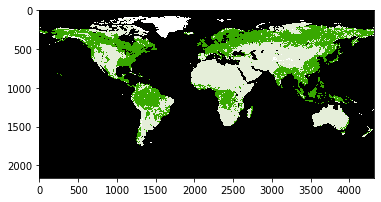

In [11]:
# inspect
with rio.open('data/hydeAnthromesExport.tif') as src:
    print(src.profile)
    rgbimg = src.read((1,2,3))
    dims = rgbimg.shape[1:]
    rio.plot.show(rgbimg)

In [ ]:
# note subprocess output printed to terminal
with rio.open('data/hydeAnthromesExport.tif') as src:
    with skvideo.io.FFmpegWriter("data/hydeAnthromesVideo2.mp4",
                                 outputdict={'-vcodec':'libx264',
                                             '-s':"{}x{}".format(dims[0], dims[1]),
                                             '-pix_fmt':'yuv420p'
                                 }, verbosity=1) as dst:
        # read 3 bands at a time as RGB components of frame
        for i in range(src.profile['count']//3):
            frame = src.read([i*3+1, i*3+2, i*3+3])
            # rio puts bands on axis 0; skvideo wants rgb on last axis
            frame = np.moveaxis(frame, 0, 2)
            dst.writeFrame(frame)

/usr/bin/ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 4320x2160 -i - -vcodec libx264 -s 4320x2160 -pix_fmt yuv420p /home/notebooks/data/hydeAnthromesVideo2.mp4
